In [1]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
import analysis.lib.purification.purify_ssro as pu_ssro;reload(pu_ssro)
%matplotlib inline

reloaded
reloaded
reloaded


This notebook collects all adwin phase feedback calibrations that were conducted during the purification experiment.
The goal is to obtain an estimate for the phase feedback drift per day (long term drift).
To this end, we analyze all data and match the fitted and expected frequencies.

In [3]:
def setup_selector(setup,lt3_option,lt4_option):
    if setup =='lt3':
        return lt3_option
    elif setup == 'lt4':
        return lt4_option
    else:
        raise NameError('unknown setup!!!')

def get_folders(setup):
    base_dir = r"D:\measuring\data"
    
    base_folder = base_dir + setup_selector(setup,'\phase_comp_lt3','\phase_comp_lt4')
    contains = setup_selector(setup,'Pippin_SIL2_ADwin_phase_compensation','')
    
    timestamps = []
    folders = []
    start_time = '20161001_000000'
    stop_time = '20160701_000000'
    
    while tb.latest_data(contains = contains,newer_than = stop_time,older_than = start_time,
                         raise_exc = False,folder = base_folder):
        t,f = tb.latest_data(contains = contains,newer_than = stop_time,older_than = start_time,folder=base_folder,
                       raise_exc = False,return_timestamp=True)
        folders = folders + [f]
        timestamps = timestamps + [t]
        start_time = t
    return folders,timestamps


def get_raw_data(setup,folders,do_plot=False):
    """
    this functions gets sweep points, RO values and initial detunings for the applied sequence.
    """
    
    ## get setup specific ssro folder
    ssro_tstamp = setup_selector(setup,'20160817_095152','20160817_094254')
    ssro_folder = tb.data_from_time(ssro_tstamp)
    detunings = []
    phases = []
    x_list = []
    y_list = []
    
    for f in folders:
        a = mbi.MBIAnalysis(f)
               
        a.get_sweep_pts()
        a.get_readout_results(name='adwindata')
        a.get_electron_ROC(ssro_folder)
        if do_plot:
            ax = a.plot_results_vs_sweepparam(ret='ax')
            
        x = a.sweep_pts.reshape(-1)[:]
        y = a.p0.reshape(-1)[:]
        
        x_list = x_list + [x]
        y_list = y_list + [y]
        detunings = detunings + [a.g.attrs['phase_detuning']]
        phases = phases + [a.g.attrs['phase_per_sequence_repetition']]
    return x_list,y_list,np.array(detunings),np.array(phases)


def prefilter_data(y_list,detunings,phases):
    det_filt = detunings > 1.
    nan_filt = np.array([True]*len(y_list))
    max_val_filt = np.array([True]*len(y_list))
    for ii,ys in enumerate(y_list):
        nans = np.isnan(ys)
        if True in nans:
            nan_filt[ii] = False
        
        if np.amax(ys) < 0.8:
            max_val_filt[ii] = False
            
    ### the phase per repetition is assumed to be approximately constant. Meaning that sudden large deviations should be discarded
    phase_filt = np.abs(phases-np.mean(phases))<10
    
    return np.logical_and(np.logical_and(np.logical_and(nan_filt,det_filt),max_val_filt),phase_filt)

def perform_fits(x_list,y_list,detunings):
    fit_res = []
    for x,y,d in zip(x_list,y_list,detunings):
        guess_A = np.amax(y)-0.5
        guess_o = 0.5
        p0, fitfunc, fitfunc_str = common.fit_exp_cos(guess_o,guess_A, 0, 200, 2,d/360., 0)
        fit_result = fit.fit1d(x,y, None, p0=p0, fitfunc=fitfunc, do_print=False, ret=True,fixed=[0,2,4])
        fit_res = fit_res + [fit_result]
    return fit_res

def convert_tstamp_to_minutes(tstamp):
    ### there are probably better ways to do this....
    mo = int(tstamp[4:6])*60*24*30
    d = int(tstamp[6:8])*60*24
    h = int(tstamp[8:10])*60
    mi = int(tstamp[10:12])
    s = float(tstamp[12:14])/60.
    return d+h+mi+s+mo



In [55]:
def analyze_phasefeedback(setup,do_plot_raw = False):
    fs,ts = get_folders(setup)
    x_list,y_list,detunings,phases = get_raw_data(setup,fs,do_plot=do_plot_raw)
    filt = prefilter_data(y_list,detunings,phases)

    ### prepare to weed out some data
    delete_data = []
    for ii,boole in enumerate(filt):
        if not boole:
            delete_data = [ii]+delete_data   
    print delete_data
    for d in delete_data:
#         print 'deleting ',fs[d]
        del x_list[d]
        del y_list[d]
    fs = np.array(fs)[filt]
    ts = np.array(ts)[filt]
    detunings = detunings[filt]
    phases = phases[filt]
    
    fit_res = perform_fits(x_list,y_list,detunings)
        
    detuning_deviation = []
    detuning_deviation_u = []
    for res,d in zip(fit_res,detunings):
        detuning_deviation = detuning_deviation + [res['params_dict']['f']*360-d]
        detuning_deviation_u = detuning_deviation_u + [res['error_dict']['f']*360]
    
    ### convert detuning deviation into the deviation from the mean measured phase.
    detuning_deviation = phases-detunings+detuning_deviation
    detuning_deviation = detuning_deviation - np.mean(detuning_deviation)

    #### convert timestamps to absolute minutes
    ts = [convert_tstamp_to_minutes(t) for t in ts]
    t0 = np.array(ts)-ts[-1]
    ### generic plot with the measurement number on the x-axis
    fig,[ax1,ax2] = plt.subplots(2)

    ax1.set_xlabel('Measurement number')
    ax1.errorbar(range(len(detuning_deviation)),detuning_deviation,detuning_deviation_u,fmt='.')
    
    ### generic plot with the measurement number on the x-axis
    ax2.set_xlabel('Absolute time (hours)')
    print 'this is the mean error bar for the fit result', np.mean(detuning_deviation_u)
    ax2.errorbar(t0/60.,detuning_deviation,detuning_deviation_u,fmt='.')
    fig.text(0,0.5,'Deviation (degrees per attempt)',rotation='vertical',size=12,ha='center',va='center')
    

    plt.subplots_adjust(hspace=0.34)
    plt.show()
    plt.close('all')
    
    ### need to also check the current measurement parameter 
    ### for the actual reality to compensate for miss calibration or multiple calibrations in a row 
    ### this should allow to do some sort of time correlation
    
    ### convert the timestamps to time difference
    t1 = np.ediff1d(t0)
    d1 = np.ediff1d(detuning_deviation)
        
    ### plot the drift over time
    fig = plt.figure()
    ax = plt.subplot()
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('time difference (hours)')
    ax.set_ylabel('Change in phase per repetition')
    plt.errorbar(t1*(-1)/60.,d1,detuning_deviation_u[:-1],fmt='.')
    plt.show()
    plt.close('all')
    
    
    return detuning_deviation

In [56]:
def histogram_and_gauss(arr):
    hist,bins = np.histogram(arr, bins=31)
    fig = plt.figure()
    ax = plt.subplot()
    binsize = bins[1]-bins[0]
    bins = bins[:-1]-binsize/2.
    plt.plot(bins,hist,'o')
    
    p0,fitfunc,fitfunc_str = common.fit_gauss(0,3,0,0.4)
    res= fit.fit1d(bins,hist,None,fitfunc=fitfunc,p0=p0,do_print=True,ret=True,fixed =[0,2])
    fit_x = np.linspace(np.amin(bins),np.amax(bins),100)
    plt.plot(fit_x,res['fitfunc'](fit_x),'r-')
    ax.set_xlabel('Deviation (degrees/attempt)')
    ax.set_ylabel('Number of occurences')
    plt.show()
    plt.close('all')
        

## LT3

[35, 33, 30, 28, 27, 24, 16, 9, 3]
this is the mean error bar for the fit result 0.0702578684141


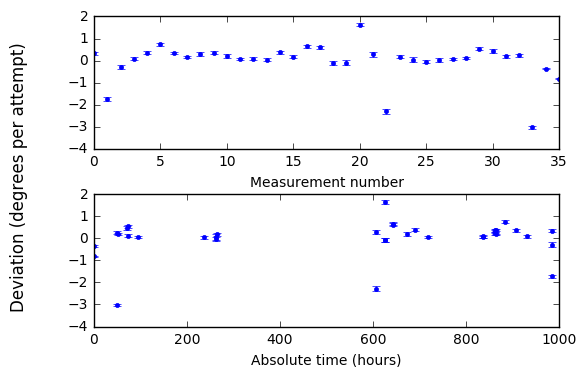

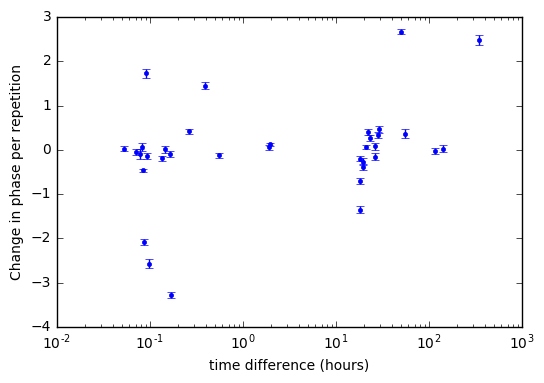

In [57]:
det_deviations_LT3 = analyze_phasefeedback('lt3')

Converged with chi squared  12.1381135222
degrees of freedom, dof  29
RMS of residuals (i.e. sqrt(chisq/dof))  0.646958761203
Reduced chisq (i.e. variance of residuals)  0.418555638697

fitted parameters at minimum, with 68% C.I.:
 0 A              7.836663 +/-   0.488074
 1 sigma          0.223671 +/-   0.016085

correlation matrix:
               A         sigma     
         A  1.000000
     sigma -0.577350  1.000000



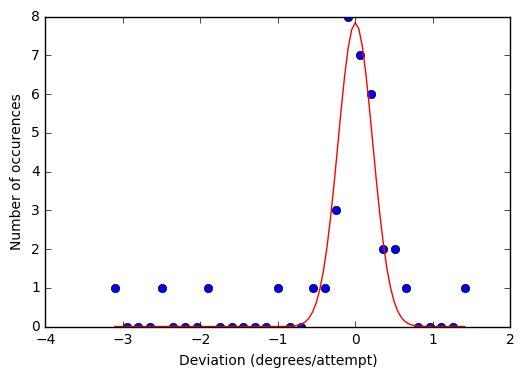

In [48]:
histogram_and_gauss(det_deviations_LT3)

[44, 43, 22, 14, 12, 11, 2, 0]
this is the mean error bar for the fit result 0.0323321238251


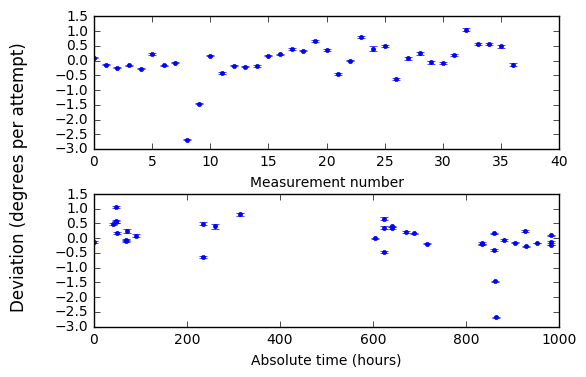

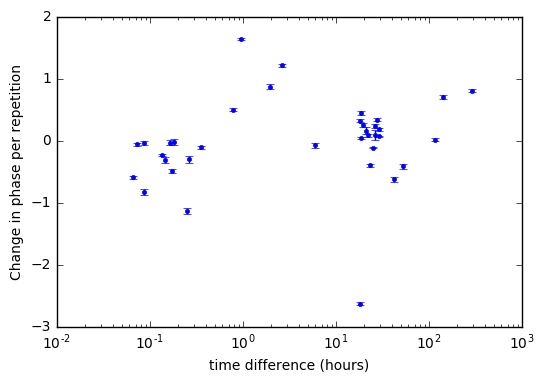

In [58]:
det_deviations_LT4 = analyze_phasefeedback('lt4',do_plot_raw=False)

Converged with chi squared  34.7077112209
degrees of freedom, dof  29
RMS of residuals (i.e. sqrt(chisq/dof))  1.0939916034
Reduced chisq (i.e. variance of residuals)  1.19681762831

fitted parameters at minimum, with 68% C.I.:
 0 A              4.284447 +/-   0.549057
 1 sigma          0.409394 +/-   0.061521

correlation matrix:
               A         sigma     
         A  1.000000
     sigma -0.582429  1.000000



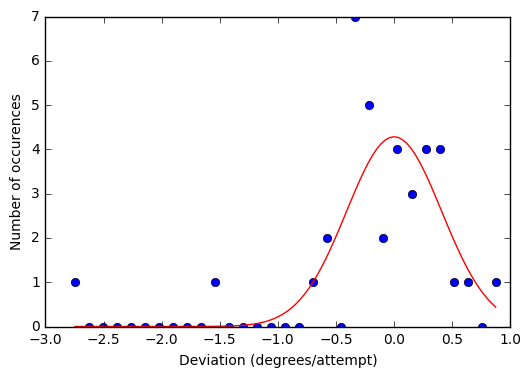

In [50]:
histogram_and_gauss(det_deviations_LT4)

Converged with chi squared  12.3940284538
degrees of freedom, dof  29
RMS of residuals (i.e. sqrt(chisq/dof))  0.653743291752
Reduced chisq (i.e. variance of residuals)  0.427380291511

fitted parameters at minimum, with 68% C.I.:
 0 A             12.535750 +/-   0.416545
 1 sigma          0.313551 +/-   0.012031

correlation matrix:
               A         sigma     
         A  1.000000
     sigma -0.577350  1.000000



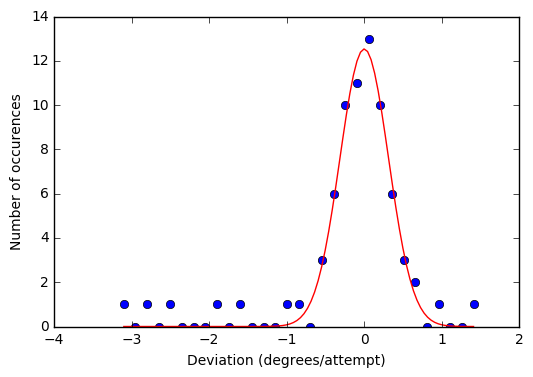

In [51]:
### LT3 and LT4 combined
histogram_and_gauss(np.append(det_deviations_LT3,det_deviations_LT4))